In [6]:
#@title Data retrieval
import os, requests

fname = '../data/joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [7]:
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [38]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
subject = 0
trial = 3
dat = alldat[subject][trial]

print({k: type(dat[k]) for k in dat.keys()})    

{'V': <class 'numpy.ndarray'>, 'targetX': <class 'numpy.ndarray'>, 'targetY': <class 'numpy.ndarray'>, 'cursorX': <class 'numpy.ndarray'>, 'cursorY': <class 'numpy.ndarray'>, 'locs': <class 'numpy.ndarray'>, 'hemisphere': <class 'list'>, 'lobe': <class 'list'>, 'gyrus': <class 'list'>, 'Brodmann_Area': <class 'list'>}


Shape of cursorX: (259920, 1)
Shape of cursorY: (259920, 1)
Shape of targetX: (259920, 1)
Shape of targetY: (259920, 1)


Text(0.5, 0, 'Time')

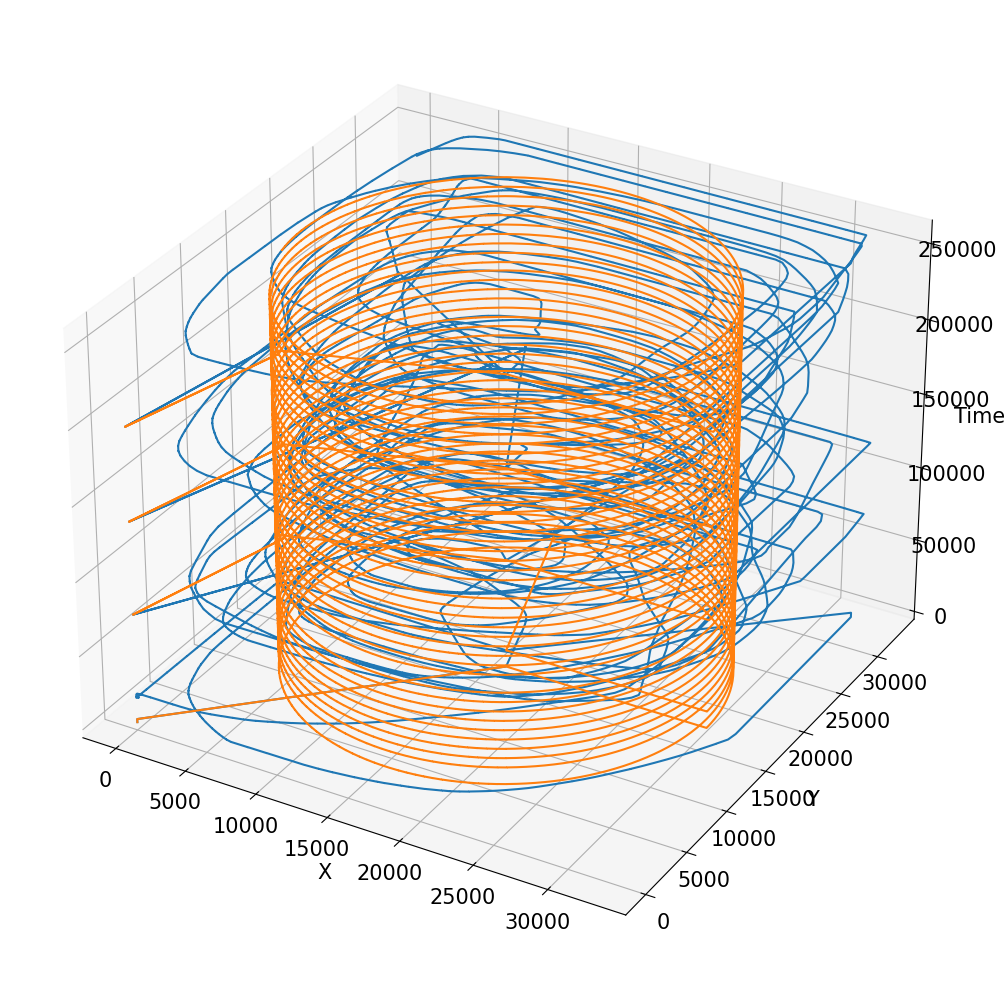

In [57]:
# data visualisation for one trial
plt.figure(figsize=(20, 20))

# Check the shapes of the arrays
print(f"Shape of cursorX: {dat['cursorX'].shape}")
print(f"Shape of cursorY: {dat['cursorY'].shape}")
print(f"Shape of targetX: {dat['targetX'].shape}")
print(f"Shape of targetY: {dat['targetY'].shape}")

# Reshape if necessary
cursorX = dat['cursorX'].reshape(-1)
cursorY = dat['cursorY'].reshape(-1)
targetX = dat['targetX'].reshape(-1)
targetY = dat['targetY'].reshape(-1)

# combine x and y to get complex numbers in polar coordinates
cursor = cursorX + 1j * cursorY
target = targetX + 1j * targetY

# project to 3d across time and plot
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(211, projection='3d')
ax.plot(np.real(cursor), np.imag(cursor), np.arange(len(cursor)))
ax.plot(np.real(target), np.imag(target), np.arange(len(cursor)))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time')

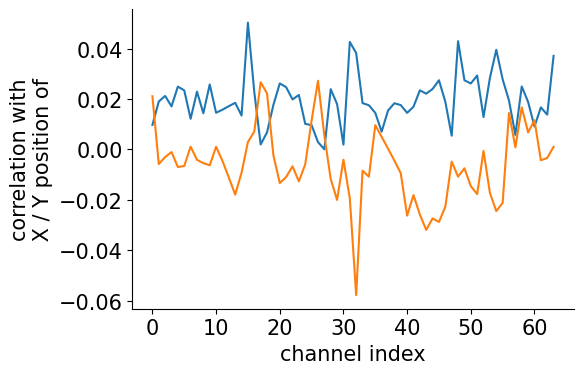

In [9]:
# compute correlations between voltage data and X/Y position of target
from scipy import signal
dat = alldat[0][1]

V = dat['V'].astype('float32')

nt, nchan = V.shape

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()

cx = np.zeros(nchan, )
cy = np.zeros(nchan, )
for j in range(nchan):
  cx[j] = np.corrcoef(V[:, j], targetX)[0, 1]
  cy[j] = np.corrcoef(V[:, j], targetY)[0, 1]

plt.subplot(1, 4, 1)
plt.plot(cx)
plt.plot(cy)
plt.ylabel('correlation with\n X / Y position of ')
plt.xlabel('channel index')
plt.show()

In [10]:
# run PCA on the voltage data in relation to the X/Y position of the target

V = dat['V'].astype('float32')


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
V_scaled = scaler.fit_transform(V, targetX)



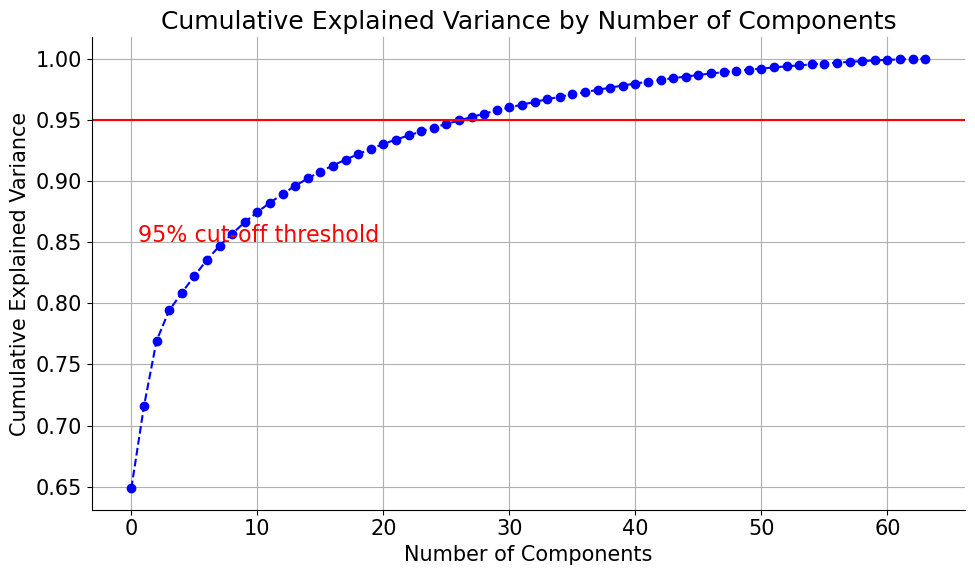

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA with all components
pca = PCA().fit(V_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=16)
plt.grid(True)
plt.show()


In [12]:
# Initialize PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)  # You can choose the number of components you want

# Fit and transform the data
V_pca = pca.fit_transform(V_scaled, targetX)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by component: {explained_variance}')

Explained variance by component: [0.64868154 0.06703278 0.05366824]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact


def plot_3d_pca(azim, elev):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(V_pca[:, 0], V_pca[:, 1], V_pca[:, 2], c='blue', edgecolor='k', s=50)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of ECoG Data')
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interact(plot_3d_pca, azim=widgets.IntSlider(min=0, max=360, step=1, value=30), elev=widgets.IntSlider(min=0, max=90, step=1, value=30))




interactive(children=(IntSlider(value=30, description='azim', max=360), IntSlider(value=30, description='elev'…

<function __main__.plot_3d_pca(azim, elev)>

In [28]:
# feature extraction

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Select the top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(V_scaled, targetX)

# Get columns selected
selected_columns = selector.get_support(indices=True)
print(f'Selected columns: {selected_columns}')

# scatter plot of the selected features in 2d and 3d with widgets
def plot_2d_features(f1, f2):
    plt.figure(figsize=(10, 8))
    plt.scatter(V_scaled[:, f1], V_scaled[:, f2], c='blue', edgecolor='k', s=50)
    plt.xlabel(f'Feature {f1}')
    plt.ylabel(f'Feature {f2}')
    plt.title('2D Scatter Plot of Selected Features')
    plt.show()

def plot_3d_features(f1, f2, f3):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(V_scaled[:, f1], V_scaled[:, f2], V_scaled[:, f3], c='blue', edgecolor='k', s=50)
    ax.set_xlabel(f'Feature {f1}')
    ax.set_ylabel(f'Feature {f2}')
    ax.set_zlabel(f'Feature {f3}')
    ax.set_title('3D Scatter Plot of Selected Features')
    plt.show()

# iter by selected columns, max by selected columns, min by selected columns
interact(plot_2d_features, f1=widgets.IntSlider(min=0, max=max(selected_columns), step=1, value=0), f2=widgets.IntSlider(min=0, max=max(selected_columns), step= 1, value=1))

Selected columns: [ 5  7 12 13 14 16 26 43 58 59]


interactive(children=(IntSlider(value=0, description='f1', max=59), IntSlider(value=1, description='f2', max=5…

<function __main__.plot_2d_features(f1, f2)>